# GC Dawson
This notebook will try to reproduce Denys's results so we can test some pragmatic things.

In [1]:
data = "data"
geom = "Al128"
temperature = 3000

In [2]:
def fermi(x, m, beta):
    from numpy import exp
    try:
        return 1.0 / (1 + exp(beta * (x - m)))
    except OverflowError:
        return 0
kb = 3.1668114 * 10**(-6)
beta = 1 / (temperature * kb)
print(beta)

105.25834703428607


Read in the matrices and metadata.

In [3]:
from scipy.io import mmread
from numpy import identity
H = mmread(f"{data}/{geom}_H.mtx").todense()
S = mmread(f"{data}/{geom}_S.mtx").todense()
I = identity(H.shape[0])

In [4]:
from yaml import load, SafeLoader
with open(f"{data}/{geom}_meta.yaml") as ifile:
    meta = load(ifile, Loader=SafeLoader)

Transform to the orthogonal representation to reduce the amount of code.

In [5]:
from numpy import sqrt
def funm_herm(a, func):
    from scipy.linalg import eigh
    w, v = eigh(a)
    w = func(w)
    return (v * w) @ v.conj().T
isq = funm_herm(S, lambda x: -1/sqrt(x))
Horth = isq @ H @ isq

Get the reference solution.

In [6]:
def get_exact(w, v, occ, beta):
    from numpy import identity, diag, trace
    imat = identity(len(w))
    left = w[0]
    right = w[-1]
    refD = 1*imat

    while abs(trace(refD) - occ) > 1e-8:
        mu = left  + 0.5*(right - left)
        we = [fermi(x, mu, beta) for x in w]
        refD = v.dot(diag(we)).dot(v.T)
        if trace(refD) > occ:
            right = mu
        else:
            left = mu

    return refD, mu

In [7]:
from scipy.linalg import eigh
w, v = eigh(Horth)
nocc = meta["nel"] // 2
refK, mu = get_exact(w, v, nocc, beta)
ref_occ, _ = eigh(refK)

Compute the zero temperature state.

In [8]:
pureK = v[:, :nocc] @ v[:, :nocc].T
pure_occ, _ = eigh(pureK)

Now try to use Denys's method.

In [14]:
def expm_specialized(A):
    from numpy.linalg import norm
    from numpy import ceil, log2, exp
    A_L1 = norm(A, 1)
    maxnorm = 1
    n_squarings = max(0, int(ceil(log2(A_L1 / maxnorm))))
    A = A / 2 ** n_squarings
    
    c = [
     4996033 - 13580623*exp(-1),
     212036664 - 576375408*exp(-1),
     2137326660 - 5809856220*exp(-1),
     8603087640 - 23385616800*exp(-1),
     16212644910 - 44070538050*exp(-1),
     14326743816 - 38944127376*exp(-1),
     4792295508 - 13026809796*exp(-1)
    ]
    
    R = A * c.pop() + I * c.pop()
    while c:
        R = c.pop() * I + A @ R
    for _ in range(n_squarings):
        R = R @ R
    return R

def anticommut(a, b):
    temp = a @ b
    return temp + temp.conj().T

def Fm(A):
    from numpy import sqrt
  
    c= [-978121 + 564719*sqrt(3),
     50347578 - 29068188*sqrt(3),
     -1291740987/2 + 745787007*sqrt(3)/2,
     3582447485 - 2068327020*sqrt(3),
     -84877583105/8 + 49004095455*sqrt(3)/8,
     18568932480 - 10720778166*sqrt(3),
     -20145242040 + 46523443659*sqrt(3)/4,
     109547730435/8 - 7905926457*sqrt(3),
     -726295290435/128 + 419326781445*sqrt(3)/128,
     83848386765/64 - 24204944335*sqrt(3)/32,
     -33072940615/256 + 19094671167*sqrt(3)/256]
  
    R = A * c.pop() + I * c.pop()
    
    while c:
        R = c.pop() * I + A @ R
   
    return R

In [15]:
H_larger = 0.5 * anticommut(Horth - mu * I, I - pureK)
exp_half_H_larger = expm_specialized(-0.5 * beta * H_larger)
H_less = 0.5 * anticommut(Horth - mu * I, pureK)
exp_H_less = expm_specialized(beta * H_less)
Omega = exp_half_H_larger @ Fm(exp_half_H_larger @ exp_half_H_larger) @ (I - pureK)
Omega += Fm(exp_H_less) @ pureK

In [16]:
compK = Omega.conj().T @ Omega
comp_occ, _ = eigh(compK)

Plot the spectra.

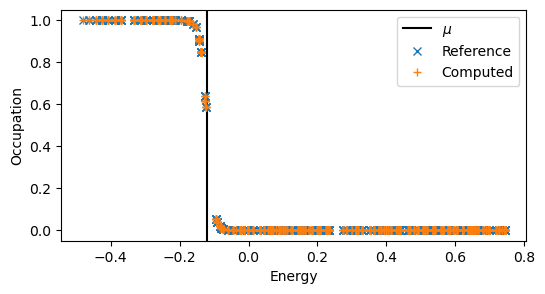

In [17]:
from matplotlib import pyplot as plt
fig, axs = plt.subplots(1, 1, figsize=(6, 3))
axs.axvline(mu, label="$\mu$", color='k')
axs.plot(w, ref_occ[::-1], 'C0x', label="Reference")
axs.plot(w, comp_occ[::-1], 'C1+', label="Computed")
axs.set_xlabel("Energy")
axs.set_ylabel("Occupation")
axs.legend()

Print the error measures.

I ideally, the norm and energy errors would be below to $10^{-3}$, and the number of electrons error more like $10^{-2}$. 

In [18]:
from numpy.linalg import norm
from numpy import trace
print("Error in the norm", norm(refK - compK))
print("For reference, the change vs. zero temperature", norm(refK - pureK))
print("Error in the energy", trace(refK @ Horth) - trace(compK @ Horth))
print("Error in the number of electrons", trace(refK) - trace(compK))

Error in the norm 0.050297894962737726
For reference, the change vs. zero temperature 2.1288846968729875
Error in the energy -0.014399556787523693
Error in the number of electrons 0.11364498654080535
